# Mixed precision timeseries for temperature

In [10]:
#THIS IS THE SAME AS NOTEBOOK 1a BUT MODIFIED TO JUST PROCESS A SIGNLE INPUT DIRECTORY


import glob
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import sys

def get_global_weights():
    
    # Get the latitude weights from a special location
    
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temperature = df.temperature    
    return temperature.latitude




def average_over_space(x,weights,use_weights):
    
    if use_weights:
        return x.weighted(weights).mean(("longitude", "latitude")) # Get the average global temperature at each timestep.
    else:
        return x.mean(("longitude", "latitude"))



def process_nc_file(f,weights,use_weights,correct_latitude_values):
    

    #Open dataset
    ds = xr.open_dataset(f)
    
    #Reset the latitude
    ds = ds.assign_coords(latitude=(correct_latitude_values))
    #And covert longitude to long1
    ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})
    
    
    
    #Get temperatures
    temperature = ds.temperature
    
    if temperature.shape != (365, 8, 48, 96):
        return False #Exit function and don't use this one
 
    surface_temperature = temperature[:,0] #Get values at surface
    surface_temperature_av = average_over_space(surface_temperature,weights,use_weights) # Average over all space, 365 points
    global_annual_average_temperature = float(surface_temperature_av.mean().values) #Average over time
    
    
    ds.close()
    return global_annual_average_temperature
    



def process_ensemble_members(subfolder,use_weights):
    
        
    print ('--------------------------')
    print ('Processing subfolder: ',subfolder)
    
    # Get the global weights at full precision.
    correct_latitude_values = get_global_weights()
    weights = np.cos(np.deg2rad(correct_latitude_values))
    weights.name = "weights"
    
    
    #Get the different available precisions in this m-directory
    root= f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/{subfolder}/'
    precision_directories = sorted(glob.glob(root+'*'))

    
    dfs = [] 
    for p in precision_directories:
        
        #Read the float precision from the filename
        precision = p.split('/')[-1].split('_')[2]
        rounding = p.split('/')[-1].split('_')[3]
        pid = precision+'_'+rounding
        print(pid,p)
    
        nc_files = sorted(glob.glob(p+'/**/*model_output*.nc',recursive=True))

        
        temp_m = []
        for n in tqdm(nc_files):
            temperature = process_nc_file(n,weights,use_weights,correct_latitude_values)
            if temperature is not False:   #False if the shape isnt correct
                temp_m.append(temperature)
            
        
        #Make it a pandas df an append to dfs
        data_dictionary = {'time': np.arange(len(temp_m)),
                           'temperature': temp_m}
        df = pd.DataFrame(data_dictionary)
        df['precision'] = pid
        dfs.append(df)
        
        
    #Now do some IO
   
    df = pd.concat(dfs).reset_index(drop=True)
    
    if use_weights:
        uw = 'weighted'
    else:
        uw = 'unweighted'
    
    
    fname = f'data/{subfolder}_temperature_timeseries_{uw}_mixedprecision.pkl'
    print('ALl iterations completed. Now saving to file:', fname)
    pd.to_pickle(df,fname)
        

# Process raw data mixed precision solutions

In [11]:
process_ensemble_members('deepdive_m5',use_weights=True)



--------------------------
Processing subfolder:  deepdive_m5
10_RNagcm /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/deepdive_m5/speedyone100yr_L2_10_RNagcm_m5


100%|██████████| 39/39 [00:03<00:00, 11.97it/s]


10_RNfordate /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/deepdive_m5/speedyone100yr_L2_10_RNfordate_m5


100%|██████████| 19/19 [00:01<00:00, 12.35it/s]


10_RNinifluxes /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/deepdive_m5/speedyone100yr_L2_10_RNinifluxes_m5


100%|██████████| 19/19 [00:01<00:00, 12.59it/s]


10_RNstloop /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/deepdive_m5/speedyone100yr_L2_10_RNstloop_m5


100%|██████████| 39/39 [00:03<00:00, 11.92it/s]

ALl iterations completed. Now saving to file: data/deepdive_m5_temperature_timeseries_weighted_mixedprecision.pkl


# And now load and plot


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np


def round_down(num, divisor):
    return num - (num%divisor)

def calculate_residuals(df,column):
    df_truth = df.query('precision == "52_RN" ')                       # Get a ground truth that all others will be compared against.
    df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) # ...and all the others
    df_join = pd.merge(df_rest,df_truth,
                       how='left',on='time',  
                       suffixes=(None, '_truth'))                       # Join

    
    df_join['MBE'] = df_join[column] - df_join[column+'_truth']        # Residuals 1
    df_join['MAE'] = abs(df_join[column] - df_join[column+'_truth'])   # Residuals 2
    
    
    print ('Average errors over all years:')
    display(df_join.groupby(by=["precision"]).mean()) 
    
    return df_join
    
    
def plot_timeseries(df,savefig,decadal_average):
    
    #Set up plot figure
    
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))
    
    
    #Part A: TIMESERIES
    p = sns.lineplot(data=df, 
                     x="time", y='temperature',
                     ax=ax1,
                     hue="precision",style="precision",markers=True) 
    

    #Part B: RESIDUALS
    df_residual = calculate_residuals(df,'temperature')
    
    if decadal_average:
        df_decadal = df_residual.copy()
        df_decadal['decade'] = df_decadal['time'].apply(lambda x : round_down(x,10))  # Round the time down to nearest 10
        df_decadal.groupby(['decade','precision']).mean()                             # Group by
        df_decadal['decade'] = df_decadal['decade'] + 5                               # Shift point to decade centre
        
        
        df_ax2 = df_decadal
        ax2_xaxis = 'decade'
                
    else: 
        df_ax2 = df_residual
        ax2_xaxis = 'time'
        
        
    q = sns.lineplot(data=df_ax2, 
                     x=ax2_xaxis, y='MBE',
                     ax=ax2,
                     hue="precision",style="precision",markers=True,legend=True
                    ) 

        
    
    #Part C: CONFIG
    plt.subplots_adjust(wspace=0.1, hspace=0)
    ax1.set_ylabel("Global Mean Surface Temperature (K)")
    ax2.set_ylabel("Mean Bias Error (K)")

    
    ax2.set_xlabel("Time (years)")
    ax2.axhline(0.0, c='0.5', linestyle='--')
    ax1.set_title(None)
    
    
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)

    #Other config
    ax1.legend().set_title(None)
    
    
    
    
    
    
    


In [23]:
#NEW FILES
d = 'data/deepdive_m5_temperature_timeseries_weighted_mixedprecision.pkl'
df = pd.read_pickle(d)

In [24]:
#ORIGINAL FILES
f = 'data/m5_temperature_timeseries_weighted.pkl'
df_og = pd.read_pickle(f)
    

In [25]:
temperature_ensemble = pd.concat([df_og,df]).reset_index()

Average errors over all years:


,index,time,temperature,index_truth,temperature_truth,MBE,MAE
precision,,,,,,,
10_RN,19.5,19.5,290.149041,319.5,290.216829,-0.067788,0.071349
10_RNagcm,18.5,18.5,290.060686,318.5,290.184866,-0.124180,0.124180
10_RNfordate,46.5,8.5,289.572496,308.5,289.643832,-0.071336,0.071336
10_RNinifluxes,64.5,8.5,289.555675,308.5,289.643832,-0.088157,0.088157
10_RNstloop,92.5,18.5,290.064951,318.5,290.184866,-0.119915,0.119915
10_SR,119.5,19.5,290.212385,319.5,290.216829,-0.004445,0.026870


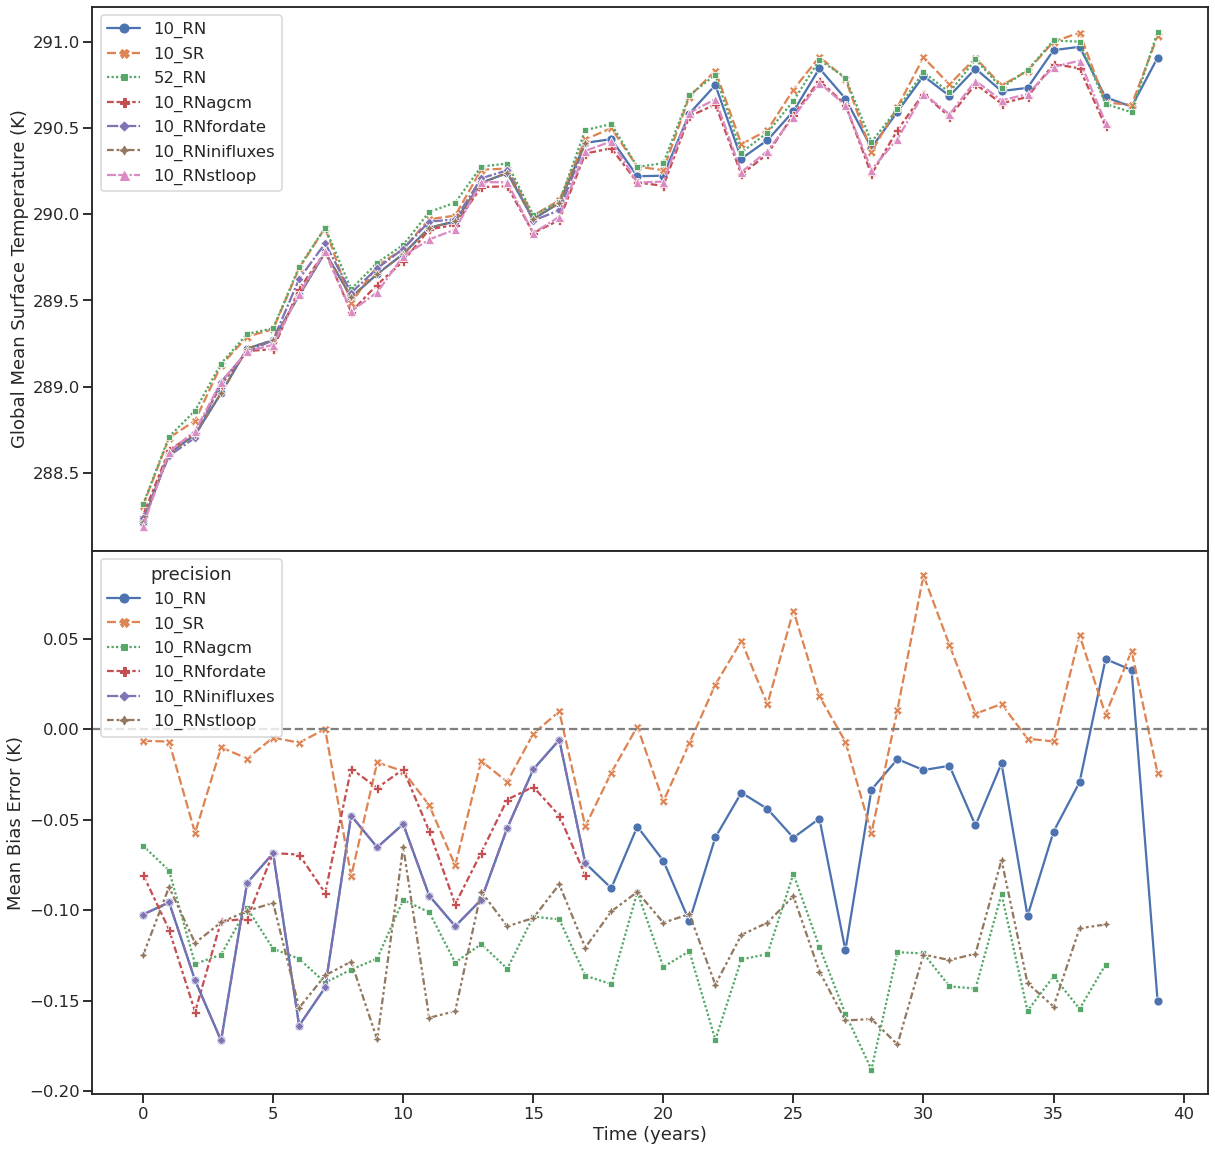

In [28]:
t = temperature_ensemble.query('time < 40 & precision != "23_RN" ')
plot_timeseries(t,savefig=None,decadal_average=False)


Average errors over all years:


,level_0,index,time,temperature,level_0_truth,index_truth,temperature_truth,MBE,MAE
precision,,,,,,,,,
10_RN,649.5,49.5,49.5,290.904266,949.5,349.5,290.939319,-0.035053,0.046497
10_RNcpl,79.5,15.5,15.5,290.116169,915.5,315.5,290.053042,0.063127,0.066028
10_SR,749.5,149.5,49.5,290.957361,949.5,349.5,290.939319,0.018042,0.035103
23_RN,849.5,249.5,49.5,290.939509,949.5,349.5,290.939319,0.000190,0.025175


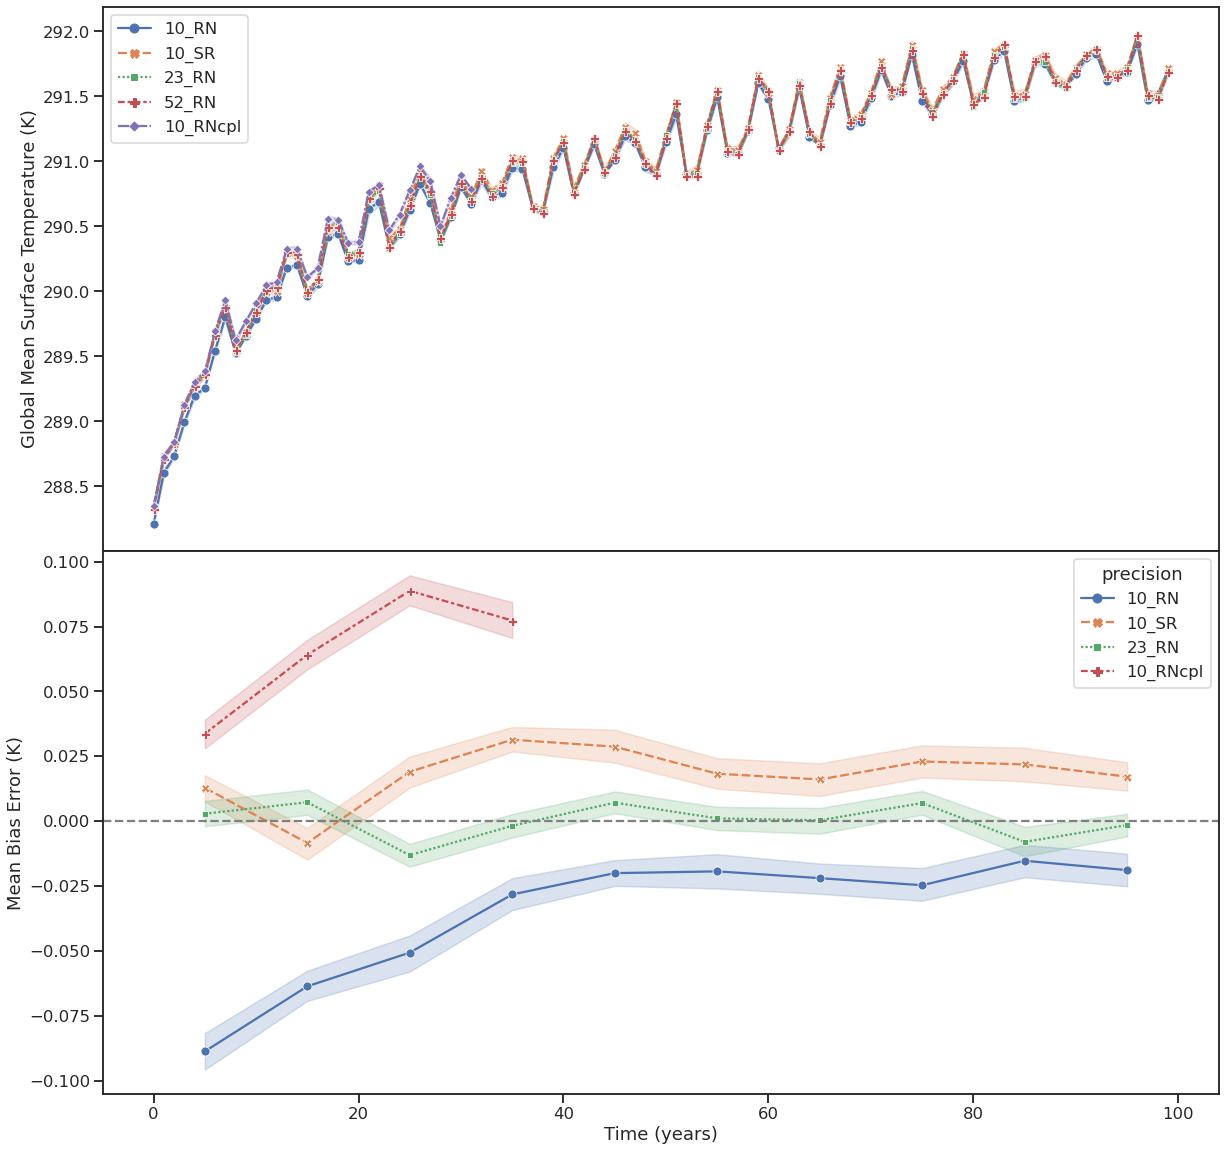

In [64]:
plot_timeseries(temperature_ensemble,savefig=None,decadal_average=True)


Average errors over all years:


,level_0,index,time,temperature,level_0_truth,index_truth,temperature_truth,MBE,MAE
precision,,,,,,,,,
10_RN,609.5,9.5,9.5,289.634706,909.5,309.5,289.71077,-0.076064,0.077250
10_RNcpl,73.5,9.5,9.5,289.759672,909.5,309.5,289.71077,0.048901,0.053174
10_SR,709.5,109.5,9.5,289.713049,909.5,309.5,289.71077,0.002279,0.030490
23_RN,809.5,209.5,9.5,289.715896,909.5,309.5,289.71077,0.005126,0.025675


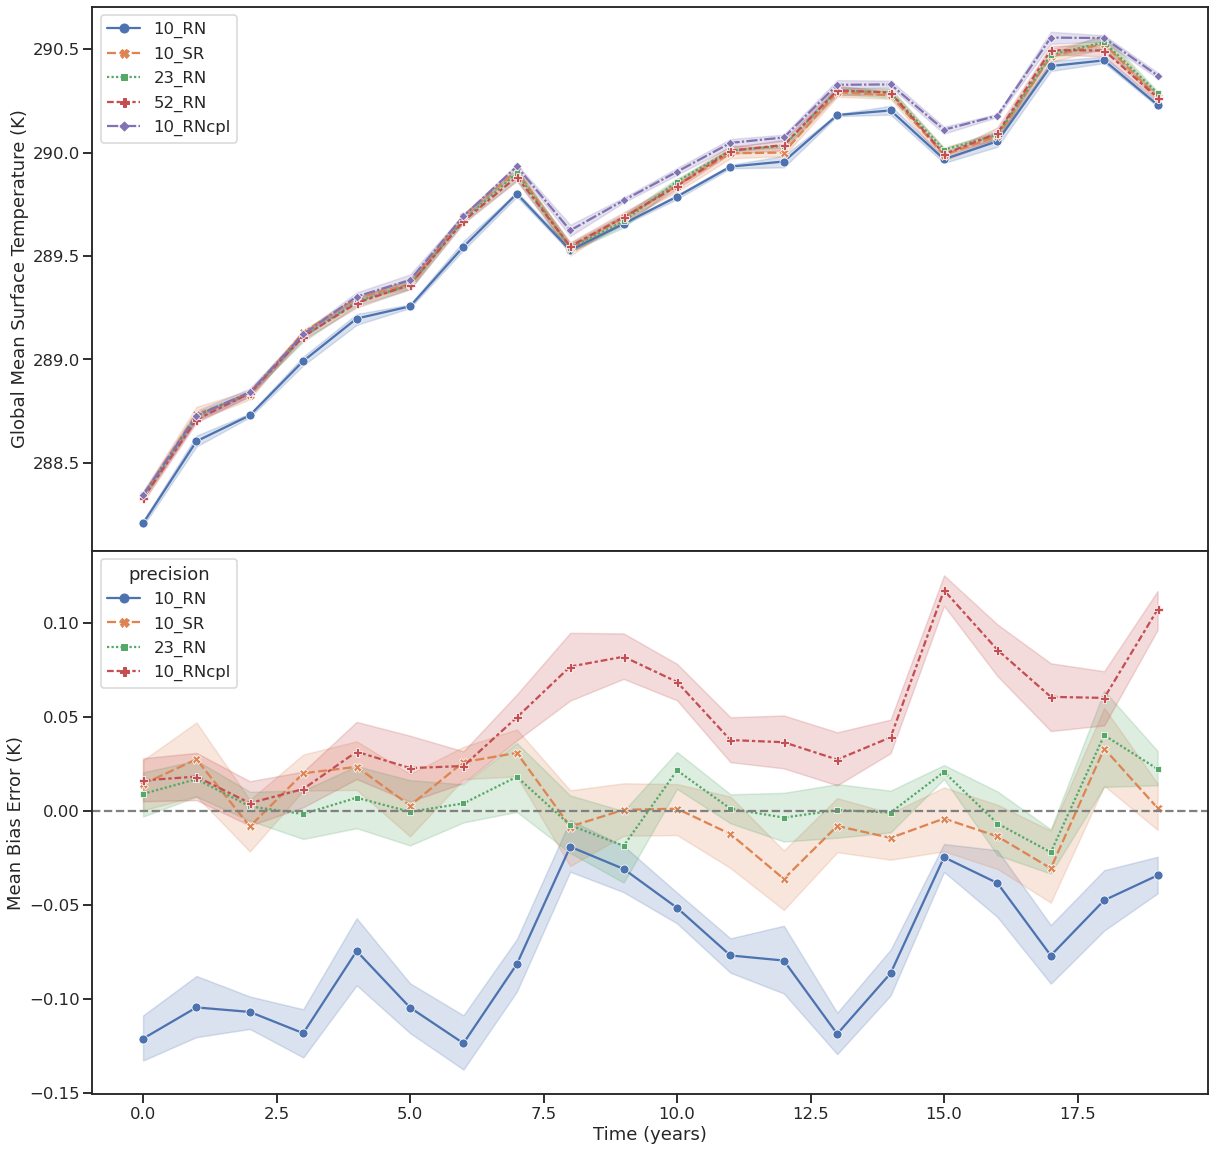

In [66]:
plot_timeseries(temperature_ensemble.query('time < 20'),savefig='figures/temperature_mixed_timeseries.png',decadal_average=False)


Average errors over all years:


,level_0,index,time,temperature,level_0_truth,index_truth,temperature_truth,MBE,MAE
precision,,,,,,,,,
10_RN,604.5,4.5,4.5,289.151944,904.5,304.5,289.240532,-0.088588,0.090173
10_RNcpl,68.5,4.5,4.5,289.274256,904.5,304.5,289.240532,0.033723,0.040613
10_SR,704.5,104.5,4.5,289.253422,904.5,304.5,289.240532,0.012890,0.028604
23_RN,804.5,204.5,4.5,289.243451,904.5,304.5,289.240532,0.002919,0.025096


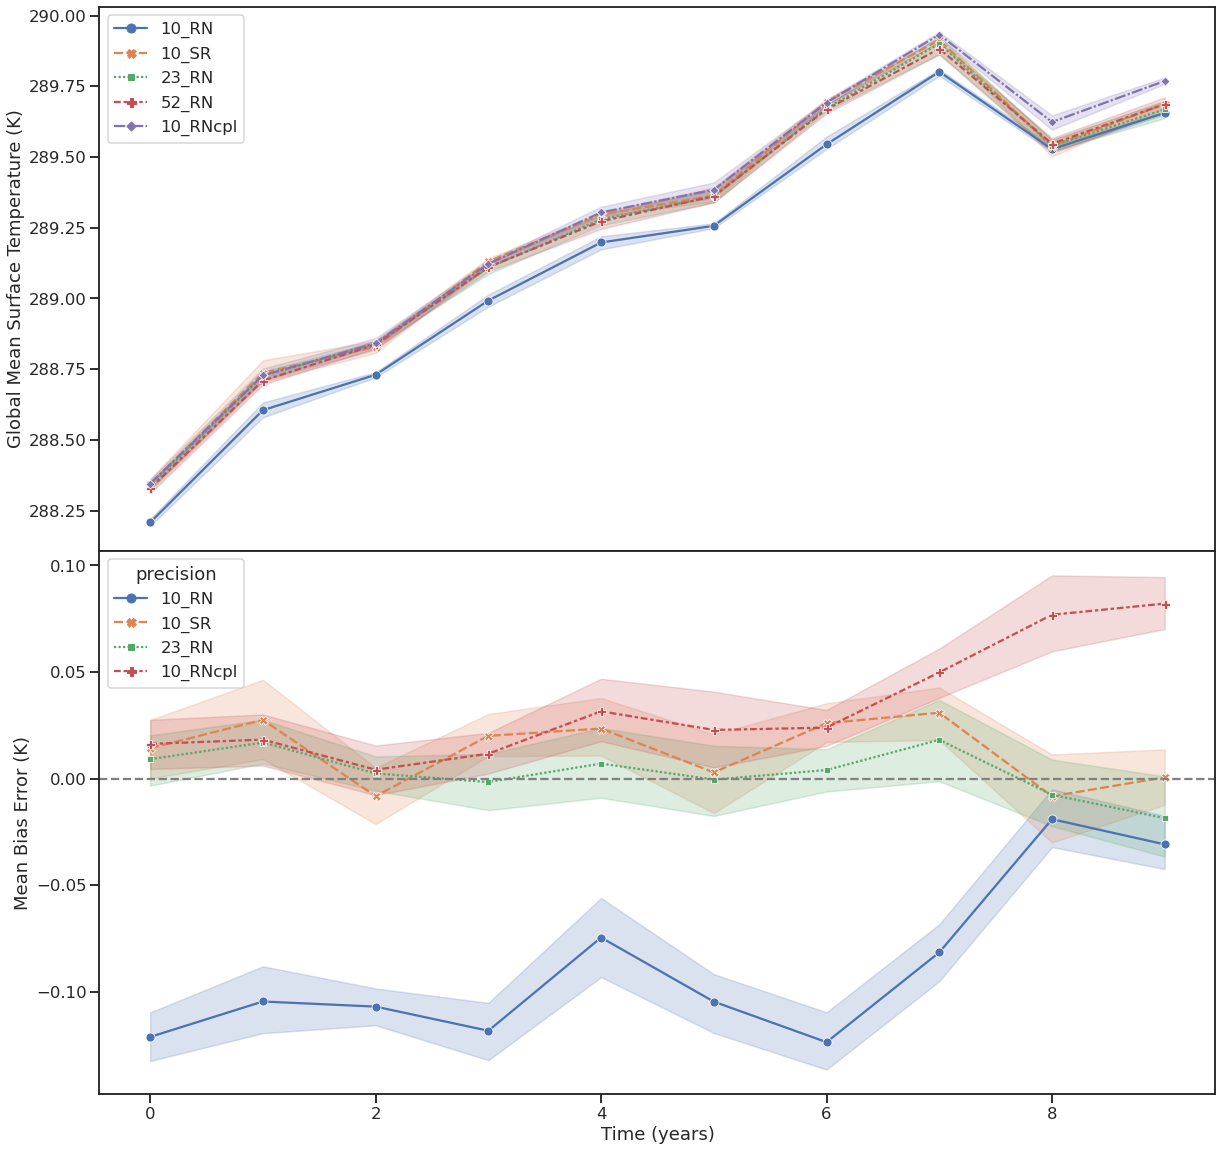

In [67]:
plot_timeseries(temperature_ensemble.query('time < 10'),savefig=None,decadal_average=False)


---

In [42]:
original_file = 'data/m5_temperature_timeseries_weighted.pkl' # 100 year file of nornal solutions 
mp_file = 'data/10year_mixed_precision_solutions_temperature_timeseries_weighted_mixedprecision.pkl' #file you just created

Average errors over all years:


,index,time,temperature,index_truth,temperature_truth,MBE,MAE
precision,,,,,,,
10_RN,9.5,9.5,289.632858,309.5,289.719286,-0.086429,0.086429
10_RNcpl,22.5,4.5,289.262395,304.5,289.256493,0.005902,0.021160
10_RNcpl2,8.5,8.5,289.670988,308.5,289.643832,0.027156,0.038098
10_RNstloop5,32.5,4.5,289.117509,304.5,289.256493,-0.138984,0.138984
10_SR,109.5,9.5,289.695977,309.5,289.719286,-0.023310,0.024418
23_RN,209.5,9.5,289.718900,309.5,289.719286,-0.000387,0.022981


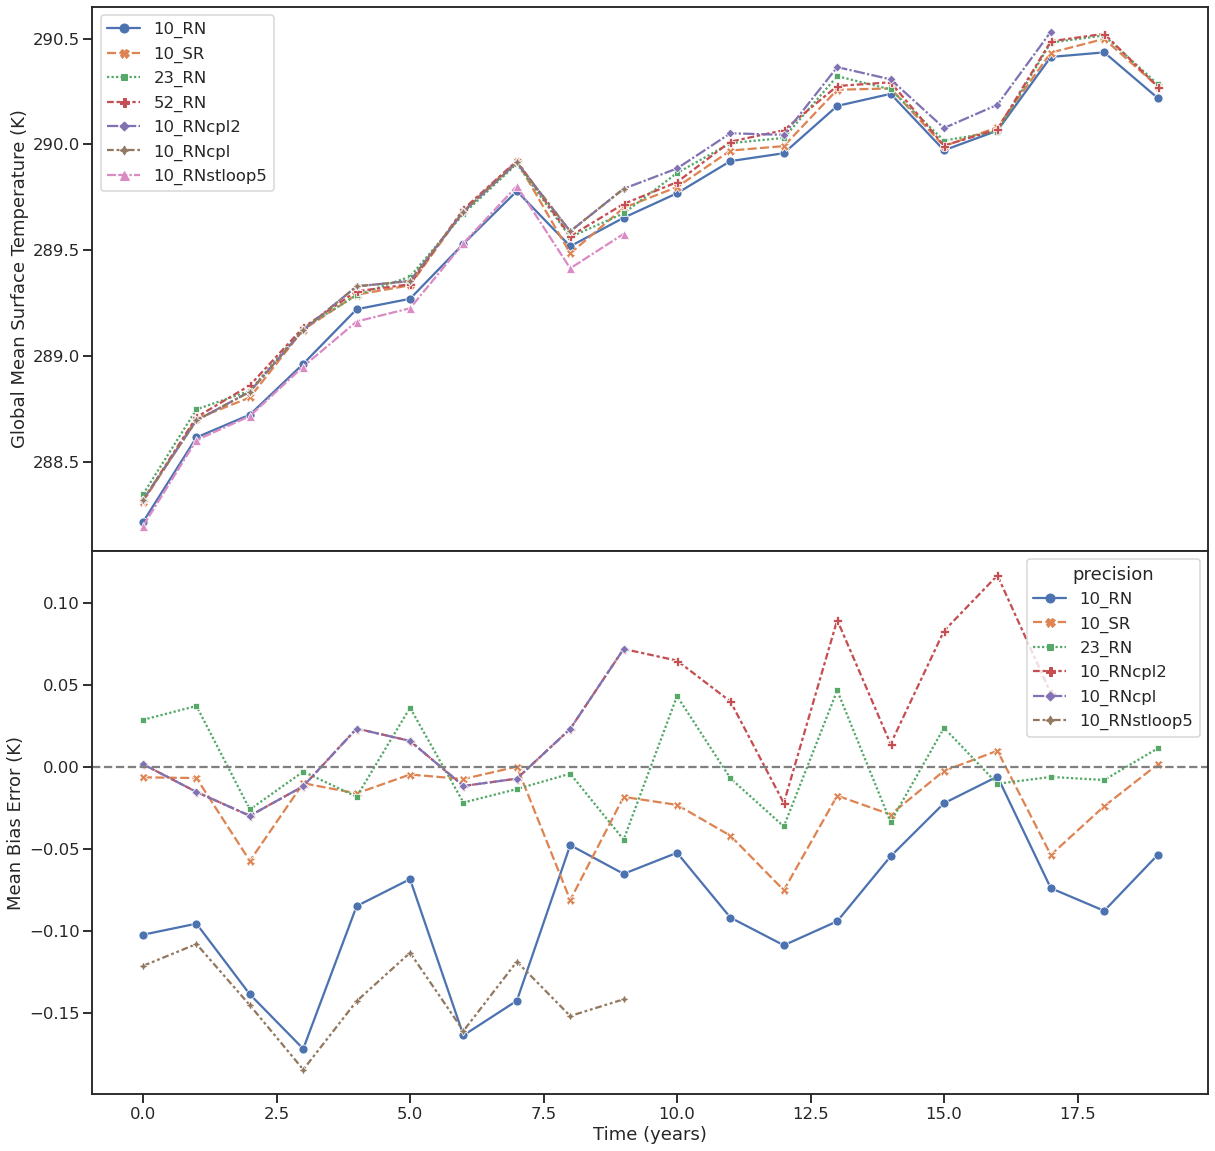

In [43]:
df_og = pd.read_pickle(original_file)
df10 = df_og.query('time < 20')
df_mp = pd.read_pickle(mp_file)
dfplot = pd.concat([df10,df_mp])
plot_timeseries(dfplot.reset_index(),savefig=None,decadal_average=False)

